In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import style
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# Suppress warnings and set a clean plotting style
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')

# Load iFood dataset
file_path = "./ifood_df.csv"
df = pd.read_csv(file_path)

# Display dataset shape and preview
shape = df.shape
head = df.head()

# Set visualization parameters
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["axes.labelweight"] = 'bold'

shape, head

((2205, 39),
     Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  MntMeatProducts  \
 0  58138.0        0         0       58       635         88              546   
 1  46344.0        1         1       38        11          1                6   
 2  71613.0        0         0       26       426         49              127   
 3  26646.0        1         0       26        11          4               20   
 4  58293.0        1         0       94       173         43              118   
 
    MntFishProducts  MntSweetProducts  MntGoldProds  ...  marital_Together  \
 0              172                88            88  ...                 0   
 1                2                 1             6  ...                 0   
 2              111                21            42  ...                 1   
 3               10                 3             5  ...                 1   
 4               46                27            15  ...                 0   
 
    marital_Widow  education_

In [2]:
# Check for missing values
missing_summary = df.isnull().sum()
missing_summary_nonzero = missing_summary[missing_summary > 0]

print(missing_summary_nonzero)

# Check for negative values in numeric columns
negative_summary = (df.select_dtypes(include=[np.number]) < 0).sum()
negative_summary_nonzero = negative_summary[negative_summary > 0]
print(negative_summary_nonzero)

# Fix negative values
df['MntRegularProds'] = df['MntRegularProds'].apply(lambda x: max(x, 0))

Series([], dtype: int64)
MntRegularProds    3
dtype: int64


Customer_Days skewness: -0.019176487275921167
Recency skewness: -0.0018740371718585932


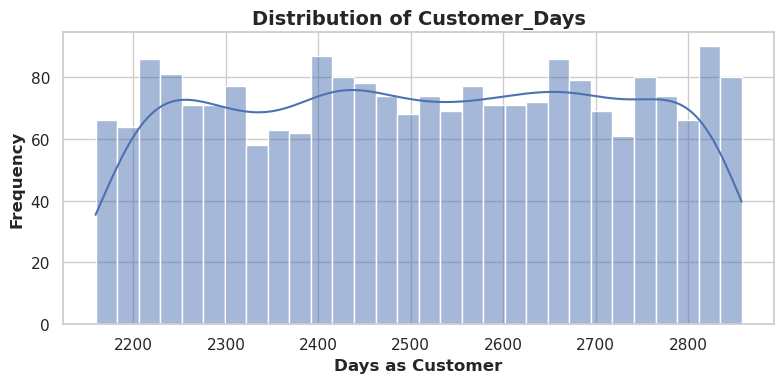

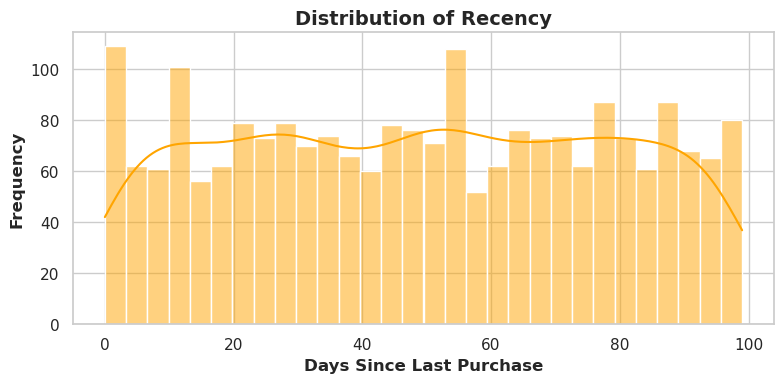

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Check skewness for Customer_Days and Recency ---
print("Customer_Days skewness:", df['Customer_Days'].skew())
print("Recency skewness:", df['Recency'].skew())

# --- Visualize distribution for Customer_Days ---
plt.figure(figsize=(8,4))
sns.histplot(df['Customer_Days'], bins=30, kde=True)
plt.title('Distribution of Customer_Days')
plt.xlabel('Days as Customer')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# --- Visualize distribution for Recency ---
plt.figure(figsize=(8,4))
sns.histplot(df['Recency'], bins=30, kde=True, color='orange')
plt.title('Distribution of Recency')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


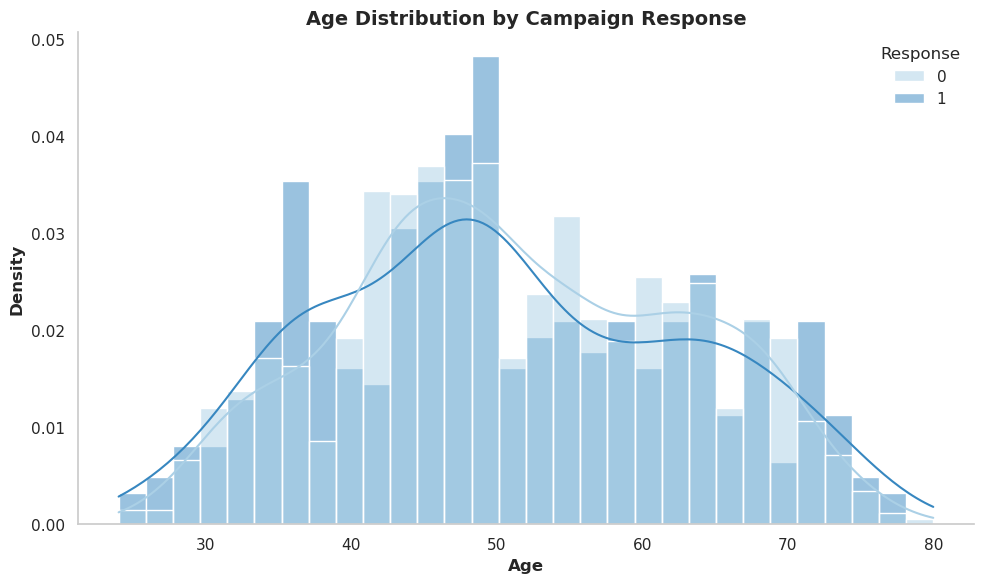

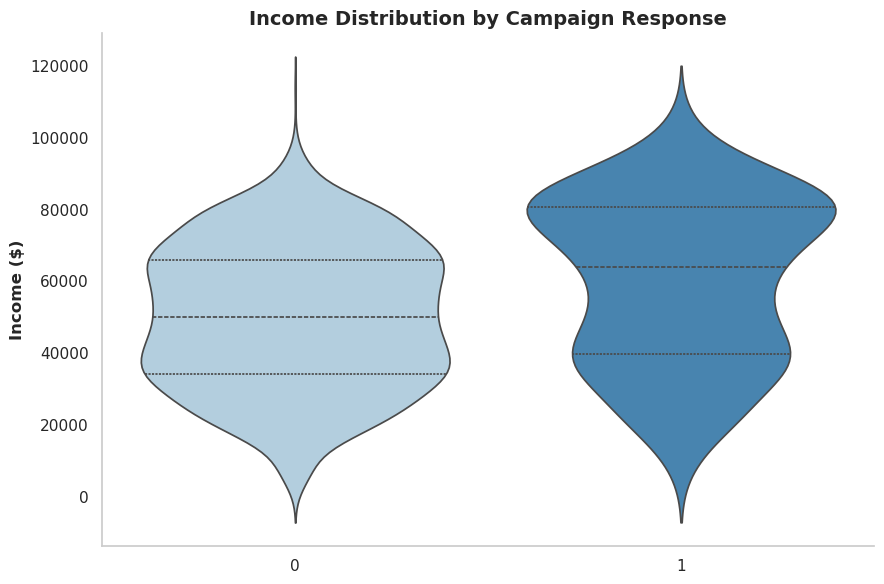

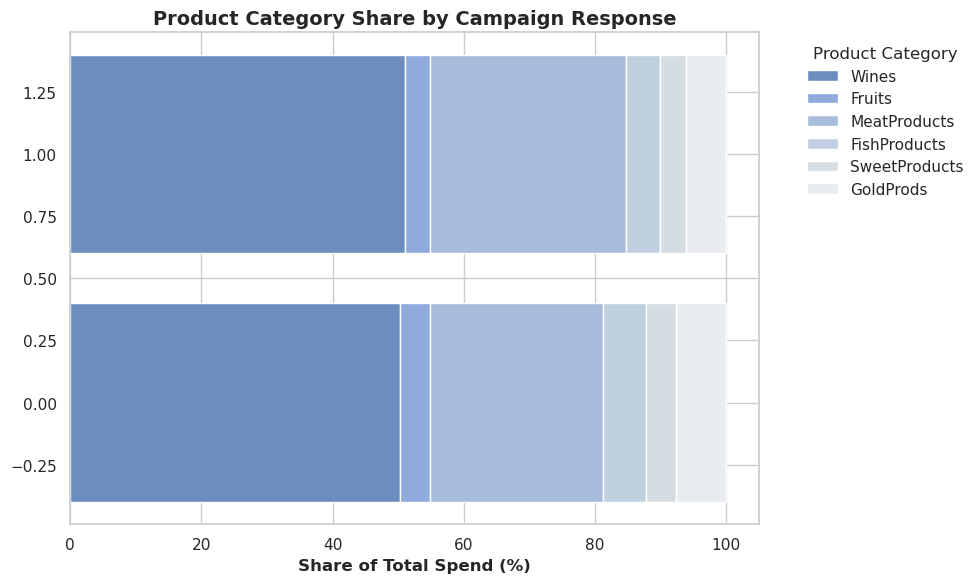

In [4]:
# KDE + Histogram: Age Distribution by Response (cleaner style)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df, x='Age', hue='Response', kde=True, stat='density',
    common_norm=False, bins=30, palette='Blues', alpha=0.5
)
plt.title('Age Distribution by Campaign Response')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(False)  # Remove grid
sns.despine()    # Clean spines
plt.tight_layout()
plt.show()

# Violin Plot: Income Distribution by Response (cleaner style)
plt.figure(figsize=(9, 6))
sns.violinplot(
    data=df, x='Response', y='Income',
    palette='Blues', inner='quartile'
)
plt.title('Income Distribution by Campaign Response')
plt.ylabel('Income ($)')
plt.xlabel('')
plt.grid(False)  # Remove grid
sns.despine()    # Clean spines
plt.tight_layout()
plt.show()

# Prepare Data for Product Mix Plot
product_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts', 
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]
product_mix = df.groupby('Response')[product_cols].sum()

# Convert to percentage share
product_mix_pct = product_mix.div(product_mix.sum(axis=1), axis=0) * 100
product_mix_pct = product_mix_pct.reset_index().melt(id_vars='Response', var_name='Category', value_name='Percent')

# Horizontal Stacked Bar Chart: Product Mix
fig, ax = plt.subplots(figsize=(10, 6))
response_labels = product_mix_pct['Response'].unique()

# Harmonious color palette
colors = ['#6c8ebf', '#8faadc', '#a8bddb', '#c1d0e1', '#d5dce2', '#e8ebef']

for i, label in enumerate(response_labels):
    subset = product_mix_pct[product_mix_pct['Response'] == label]
    left = 0
    for j, category in enumerate(product_cols):
        value = subset[subset['Category'] == category]['Percent'].values[0]
        ax.barh(label, value, left=left, color=colors[j], edgecolor='white', label=category.replace("Mnt", "") if i == 0 else "")
        left += value

ax.set_xlabel('Share of Total Spend (%)')
ax.set_title('Product Category Share by Campaign Response')
ax.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


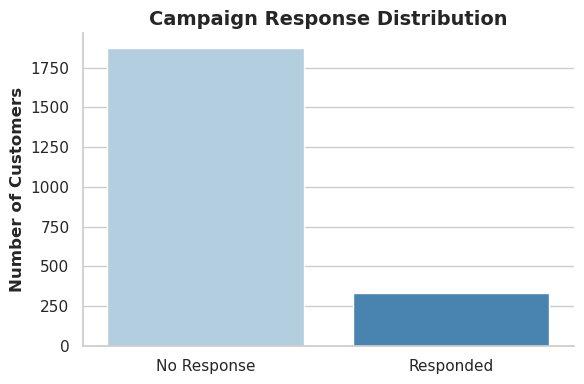

Response_Binary
0    84.9
1    15.1
Name: count, dtype: float64

In [5]:
# Define binary target variable: 1 = responded, 0 = did not respond
df['Response_Binary'] = df['Response']

# Check distribution
response_counts = df['Response_Binary'].value_counts().sort_index()

# Plot target distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=response_counts.index, y=response_counts.values, palette='Blues')
plt.xticks([0, 1], ['No Response', 'Responded'])
plt.title('Campaign Response Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

response_counts_percent = response_counts / response_counts.sum() * 100
response_counts_percent.round(2)

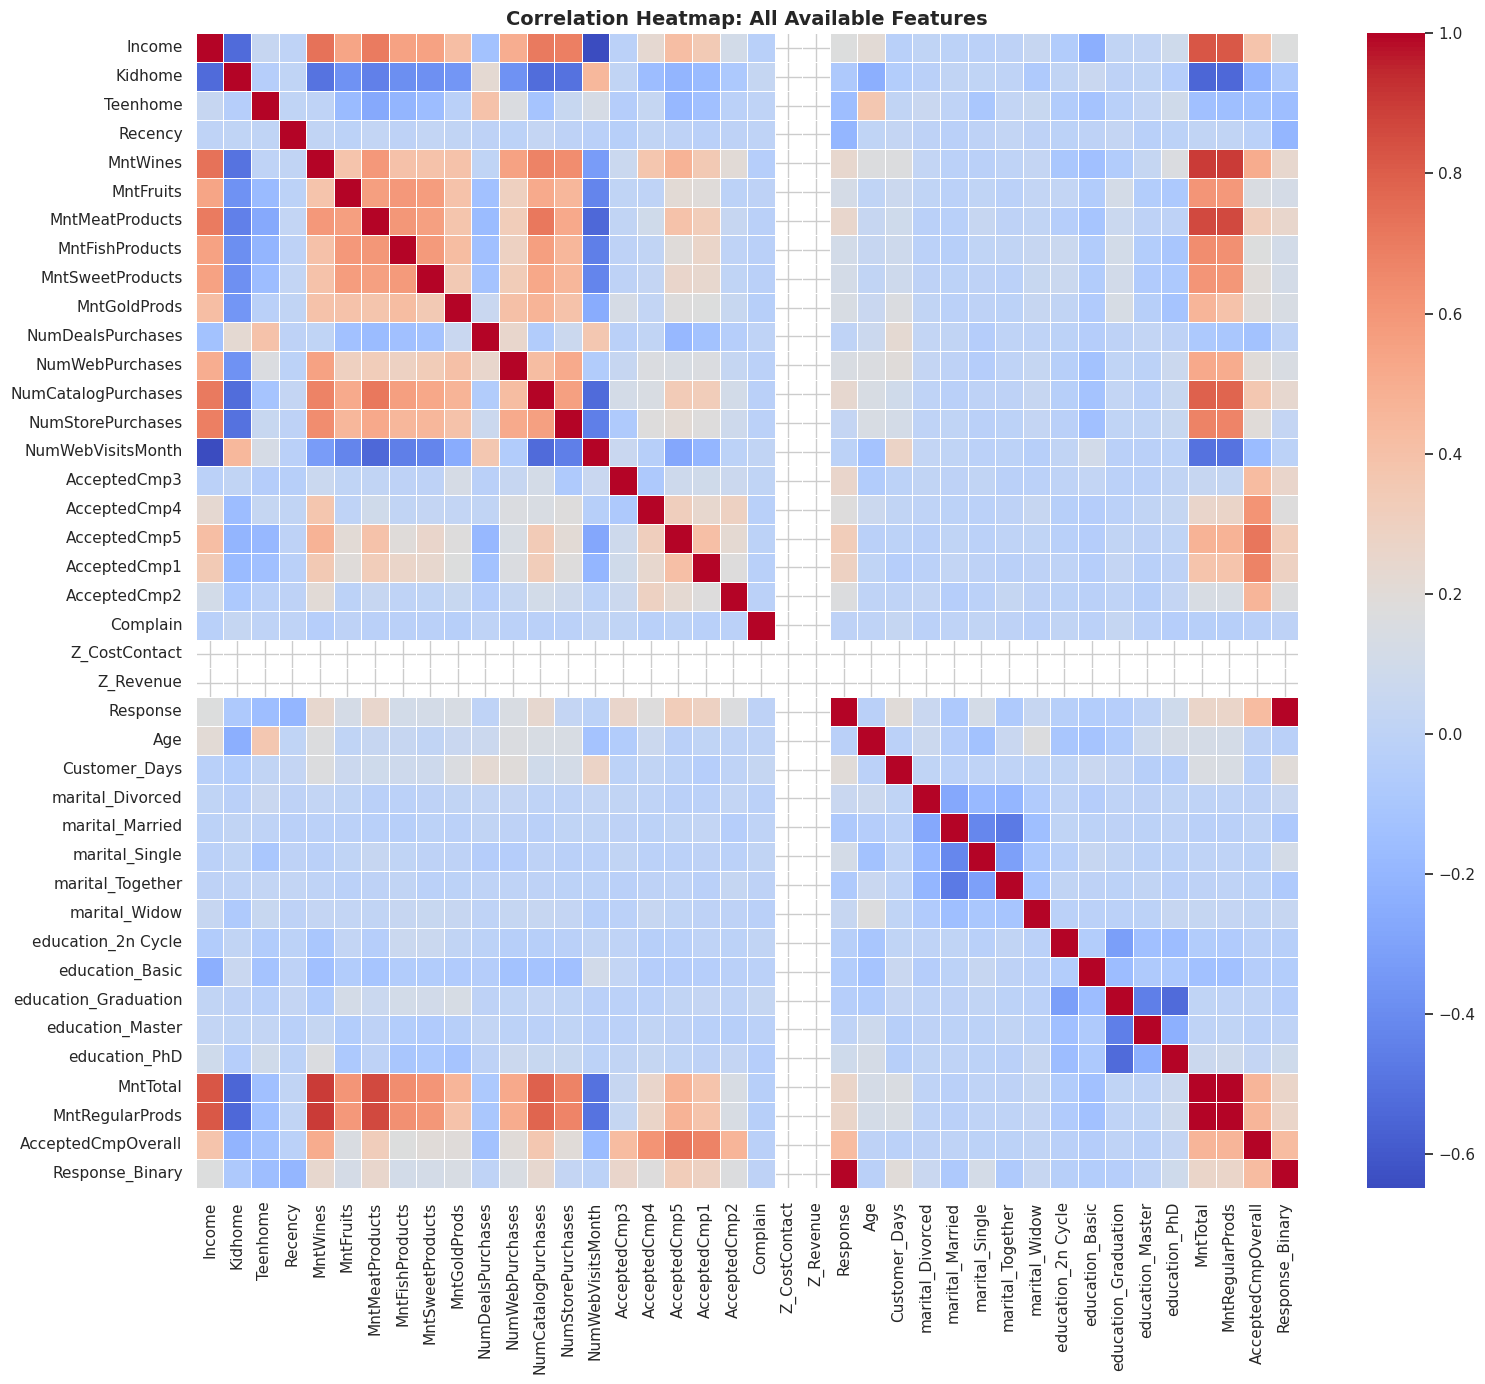

In [6]:
# Create a fresh copy of the original DataFrame for correlation analysis
df_corr_all = df.copy()

# Drop non-numeric, ID, and label columns if they exist
drop_cols = ['ID', 'Response_Label']
df_corr_all = df_corr_all.drop(columns=[col for col in drop_cols if col in df_corr_all.columns])

# Compute correlation matrix
corr_matrix_all = df_corr_all.corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix_all, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Correlation Heatmap: All Available Features')
plt.tight_layout()
plt.show()


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Prepare a copy for VIF calculation
vif_df = df_corr_all.copy()

# Drop target column and any non-numeric leftover
if 'Response' in vif_df.columns:
    vif_df = vif_df.drop(columns=['Response'])

# Add constant for intercept (needed for VIF calculation)
vif_df_const = sm.add_constant(vif_df)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_df_const.columns
vif_data["VIF"] = [variance_inflation_factor(vif_df_const.values, i)
                   for i in range(vif_df_const.shape[1])]

# Drop the constant row and sort by VIF descending
vif_data = vif_data[vif_data["Feature"] != "const"].sort_values(by="VIF", ascending=False).reset_index(drop=True)
vif_data

,Feature,VIF
0,MntMeatProducts,inf
1,MntFruits,inf
2,MntWines,inf
3,AcceptedCmp2,inf
4,AcceptedCmp4,inf
5,MntSweetProducts,inf
6,MntFishProducts,inf
7,education_Master,inf
8,AcceptedCmpOverall,inf
9,education_PhD,inf


In [8]:
# === FINAL FEATURE ENGINEERING (Updated) ===

# Start with cleaned df
df_fe = df.copy()

# --- 1. Demographic Features ---
df_fe['Total_Kids'] = df_fe['Kidhome'] + df_fe['Teenhome']
df_fe['Is_HigherEdu'] = (df_fe['education_Master'] + df_fe['education_PhD']).apply(lambda x: 1 if x > 0 else 0)
df_fe['Is_Partnered'] = (df_fe['marital_Married'] + df_fe['marital_Together']).apply(lambda x: 1 if x > 0 else 0)

# --- 2. Product Category Shares ---
product_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]

# Calculate total spend to derive shares (avoid division by zero)
df_fe['Total_Spend'] = df_fe[product_cols].sum(axis=1).replace(0, 1)

# Create share columns for each product EXCEPT meat (so meat acts as baseline)
for col in product_cols:
    if col == 'MntMeatProducts':
        continue  # Skip meat share – it will be the baseline
    share_col = col.replace("Mnt", "") + "_Share"
    df_fe[share_col] = df_fe[col] / df_fe['Total_Spend']

# --- 3. Channel Behavior ---
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df_fe['Total_Purchases'] = df_fe[purchase_cols].sum(axis=1).replace(0, 1)

df_fe['Web_Purchase_Share'] = df_fe['NumWebPurchases'] / df_fe['Total_Purchases']
df_fe['Store_Purchase_Share'] = df_fe['NumStorePurchases'] / df_fe['Total_Purchases']

# --- 4. Campaign Engagement ---
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df_fe['Total_Accepted_Campaigns'] = df_fe[campaign_cols].sum(axis=1)

# --- 5. Add Time-Based Features ---

# --- 6. Select Final Features for Modeling ---
final_features = [
    # Demographics
    'Age', 'Income', 'Total_Kids', 'Is_HigherEdu', 'Is_Partnered',
    
    # Time-based features
    'Recency', 'Customer_Days',
    
    # Channel behavior
    'Web_Purchase_Share', 'Store_Purchase_Share',
    
    # Campaign
    'Total_Accepted_Campaigns',
    
    # Behavioral flags
    'Complain',
    
    # Target
    'Response',
    
    # Product category shares (meat is baseline)
    'Wines_Share', 'Fruits_Share', 'FishProducts_Share', 'SweetProducts_Share', 'GoldProds_Share'
]

# Final modeling DataFrame
df_model = df_fe[final_features].copy()

print("✅ Final feature engineering complete.")
print(f"Final dataset shape: {df_model.shape}")
print("Columns included:")
print(df_model.columns.tolist())


✅ Final feature engineering complete.
Final dataset shape: (2205, 17)
Columns included:
['Age', 'Income', 'Total_Kids', 'Is_HigherEdu', 'Is_Partnered', 'Recency', 'Customer_Days', 'Web_Purchase_Share', 'Store_Purchase_Share', 'Total_Accepted_Campaigns', 'Complain', 'Response', 'Wines_Share', 'Fruits_Share', 'FishProducts_Share', 'SweetProducts_Share', 'GoldProds_Share']


In [9]:
from sklearn.model_selection import train_test_split

# --- Generate seeds from student ID ---
student_id = 320169
# Reverse digits of your student ID to create 5 seeds
seeds = [int(digit) for digit in str(student_id)[::-1]]  # -> [9, 6, 1, 0, 2]

print("Seeds generated from student ID:", seeds)

# --- Define features (X) and target (y) ---
X = df_model.drop(columns=['Response'])   # All predictors
y = df_model['Response']                  # Target variable

# --- Perform the first split using the first seed ---
seed = seeds[0]  # use the first seed initially
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Seeds generated from student ID: [9, 6, 1, 0, 2, 3]
(1764, 16) (441, 16) (1764,) (441,)


In [10]:
# Define the logistic regression pipeline with scaling
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=seed))
])

# Train the model
logreg_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

logreg_pipeline


,steps,"[('scaler', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [11]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Seed list based on student ID
seeds = [38645, 37440, 38166, 39035, 38584]

# Store results
results = []

# Features and target
X = df_model.drop(columns='Response')
y = df_model['Response']

# Run logistic regression for each seed
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(solver='liblinear', penalty='l2', random_state=seed))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        'Seed': seed,
        'Accuracy': round(acc * 100, 2),
        'ROC AUC': round(auc, 3)
    })
    results_df = pd.DataFrame(results)
results_df

,Seed,Accuracy,ROC AUC
0,38645,90.48,0.884
1,37440,90.93,0.922
2,38166,89.34,0.907
3,39035,88.21,0.908
4,38584,89.57,0.903


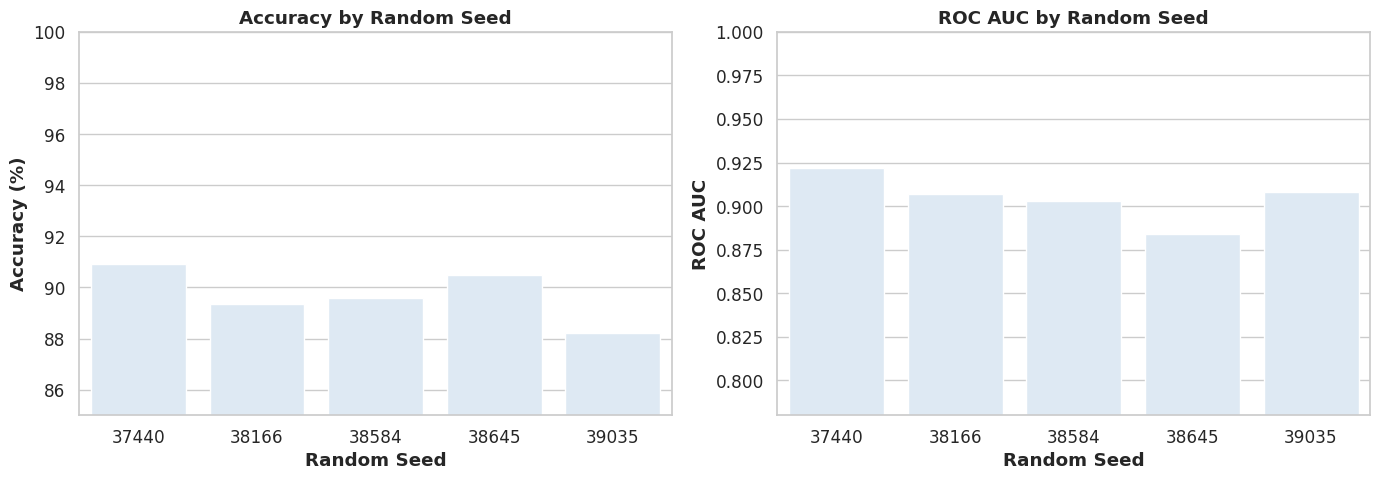

In [12]:
# Set visual style
sns.set(style='whitegrid', palette='Blues', font_scale=1.1)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy bar plot
sns.barplot(x='Seed', y='Accuracy', data=results_df, ax=axes[0])
axes[0].set_title('Accuracy by Random Seed')
axes[0].set_ylim(85, 100)
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_xlabel('Random Seed')

# ROC AUC bar plot
sns.barplot(x='Seed', y='ROC AUC', data=results_df, ax=axes[1])
axes[1].set_title('ROC AUC by Random Seed')
axes[1].set_ylim(0.78, 1)
axes[1].set_ylabel('ROC AUC')
axes[1].set_xlabel('Random Seed')

plt.tight_layout()
plt.show()


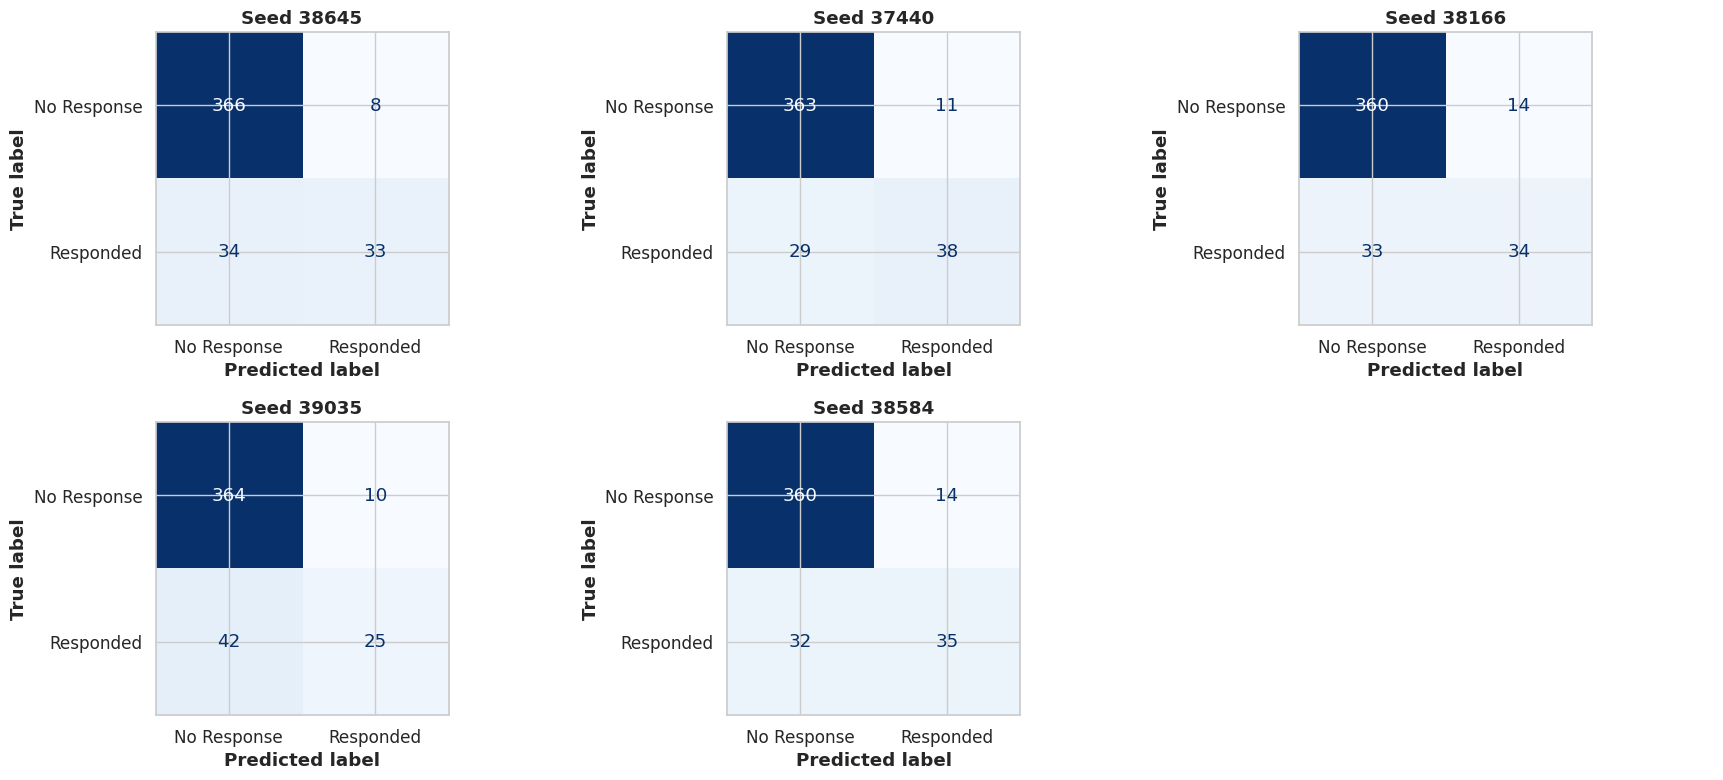

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create a 2x3 grid (fits 5 seeds; 1 panel will be unused)
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Loop through each seed and plot confusion matrix
for i, seed in enumerate(seeds):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(solver='liblinear', penalty='l2', random_state=seed))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["No Response", "Responded"])
    ax = axes.flat[i]                # <-- single Axes, not a row array
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"Seed {seed}")

# Hide the unused last subplot
for j in range(len(seeds), axes.size):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()


In [16]:
import numpy as np

# Fit final model on full data using one seed (can repeat with average later)
seed = seeds[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', penalty='l2', random_state=seed))
])
final_model.fit(X_train, y_train)

# Get feature names from the pipeline
feature_names = X.columns
coefficients = final_model.named_steps['logreg'].coef_[0]

# Create odds ratios and sort
odds_ratios = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
}).sort_values(by='Odds Ratio', ascending=False)
odds_ratios


,Feature,Coefficient,Odds Ratio
9,Total_Accepted_Campaigns,1.200058,3.320310
6,Customer_Days,1.015445,2.760592
3,Is_HigherEdu,0.466905,1.595050
0,Age,0.031296,1.031791
7,Web_Purchase_Share,0.011635,1.011703
1,Income,0.000569,1.000569
10,Complain,-0.062499,0.939414
15,GoldProds_Share,-0.090850,0.913155
2,Total_Kids,-0.153753,0.857484
12,Fruits_Share,-0.223869,0.799420


In [17]:
import statsmodels.api as sm

# === SIGNIFICANCE TESTING WITH STATSMODELS ===

# Use the same X and y from your sklearn model
X_sm = sm.add_constant(X)   # Add constant for intercept
y_sm = y

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y_sm, X_sm)
result = logit_model.fit()

# Get summary table
summary_df = result.summary2().tables[1].reset_index()
summary_df.columns = ['Feature', 'Coefficient', 'StdErr', 'z', 'P>|z|', '[0.025', '0.975]']

# Calculate Odds Ratio and add to the table
summary_df['Odds Ratio'] = np.exp(summary_df['Coefficient'])

# Round for clarity
summary_df = summary_df.round(4)

# Display the final significance table
summary_df


Optimization terminated successfully.
         Current function value: 0.242191
         Iterations 8


,Feature,Coefficient,StdErr,z,P>|z|,[0.025,0.975],Odds Ratio
0,const,-7.7061,1.4724,-5.2338,0.0000,-10.5920,-4.8203,0.0005
1,Age,0.0041,0.0070,0.5844,0.5589,-0.0096,0.0178,1.0041
2,Income,0.0000,0.0000,0.3049,0.7604,-0.0000,0.0000,1.0000
3,Total_Kids,-0.0789,0.1392,-0.5666,0.5710,-0.3517,0.1940,0.9242
4,Is_HigherEdu,1.0355,0.1785,5.8018,0.0000,0.6857,1.3854,2.8166
5,Is_Partnered,-1.2967,0.1645,-7.8824,0.0000,-1.6191,-0.9743,0.2734
6,Recency,-0.0339,0.0031,-11.0208,0.0000,-0.0400,-0.0279,0.9666
7,Customer_Days,0.0050,0.0005,10.7402,0.0000,0.0041,0.0059,1.0050
8,Web_Purchase_Share,0.2702,0.7854,0.3440,0.7308,-1.2692,1.8096,1.3103
9,Store_Purchase_Share,-5.0506,0.7308,-6.9115,0.0000,-6.4828,-3.6183,0.0064
